### Synaptic sign switching simulation in a co-releasing neural circuit model
#### Shun | Elliot
Modeling synaptic plasticity in a circuit involving a rare population of glutamate/GABA co-relasing neurons:
- Endopeduncular Nucleus(EP) to Lateral Habenula(LHb) to Dopamine(DAN)

Background:
- In biology, optogenetic stimulation at LHb paired with reward then punishment leads to synaptic sign switching at EP.
- In artificial neural networks, an "optogenetic" stimulus/input (ex. MNIST label 4) paired with target value of 1 (reward) then 0 (punishment) leads to weight sign switching at EP layer.

Goal:
- Compare sign-fixed networks (Dale's Law) to our co-releasing circuit to explore advantages of co-release mechanism in synaptic sign switching.

Corelease MLP Framework:
- Input layer: Ctx->EP (sign-fixed)
- Hidden Layer: EP->LHb (co-releasing)
- Output: LHb->DAN (sign-fixed negative)


In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch.nn.utils import clip_grad_value_
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split

import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import os
import json
import time
import wandb
import pickle
from copy import deepcopy

from train import (TrainerMLE, CustomWeightDecayOptimizer, MNIST)
from model_setup import Corelease_Model, TopKLinear

from utils import (
    weight_changes, plot_distance, plot_loss, generate_opto_loader, get_activations,
    plot_layer_activation, scatterboxplot, imshow, calculate_weights, calculate_EIindex,
    get_training_params, save_weights_to_pickle, load_weights_from_pickle,
    calculate_weight_metrics, calculate_all_weight_metrics, plot_excitatory_inhibitory_scatter,
    plot_weight_histograms, plot_weight_differences, plot_EI_index_distribution
)

### Define Parameters

In [3]:
epochs = 20
opto_category = 4
out_features = 1
lr = 0.01

training_loss_summary, test_accuracy_summary, val_accuracy_summary, initial_params_summary, trained_params_summary, params_summary = {}, {}, {}, {}, {}, {}
network_name = 'MNIST_TopK_MSE'

# Training sessions
random_learning = True # always true
reward_learning = True
punish_learning = True

### Setup Model

In [4]:
model = Corelease_Model(in_features=784, h1=512, h2=512, out_features=1)

base_optimizer = optim.Adam(params = model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
optimizer = CustomWeightDecayOptimizer(model = model, optimizer = base_optimizer)

loss_function = "MSE"

if loss_function == "CrossEntropy":
    criterion = nn.CrossEntropyLoss()
elif loss_function == "MSE":
    criterion = nn.MSELoss()

### Load Data

In [5]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

random_train_data = MNIST(train_data, out_features = out_features)
reward_train_data = MNIST(train_data, out_features = out_features, opto_category = opto_category, opto_target = 1)
punish_train_data = MNIST(train_data, out_features = out_features, opto_category = opto_category, opto_target = 0)

random_train_data, random_valid_data = random_split(random_train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
reward_train_data, reward_valid_data = random_split(reward_train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))
punish_train_data, punish_valid_data = random_split(punish_train_data, [50000, 10000], generator=torch.Generator().manual_seed(42))

### Set appropriate targets for optogenetic stimulus label (reward: 1, punish: 0)

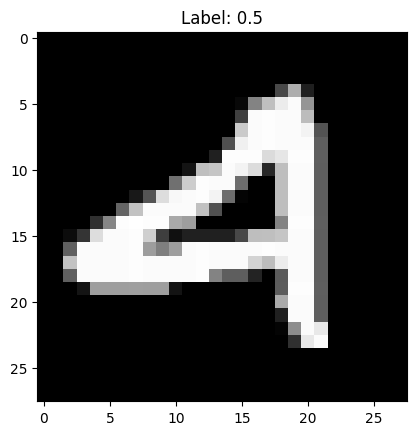

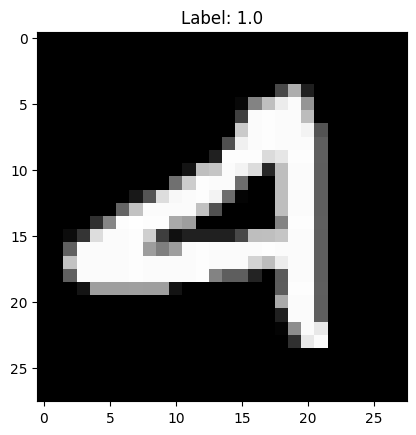

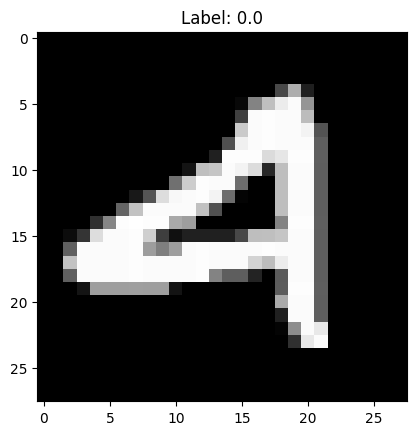

In [6]:
random_train_loader = DataLoader(random_train_data, batch_size=256, shuffle=False)
reward_train_loader = DataLoader(reward_train_data, batch_size=256, shuffle=False)
punish_train_loader = DataLoader(punish_train_data, batch_size=256, shuffle=False)

# Get opto loader
random_opto_loader = generate_opto_loader(random_train_loader, opto_category, plot=True)
reward_opto_loader = generate_opto_loader(reward_train_loader, opto_category, plot=True)
punish_opto_loader = generate_opto_loader(punish_train_loader, opto_category, plot=True)

### Train MLP to learn all stimuli/ labels

EP.pre_w: Positive: 50.12%; Negative: 49.88%; Zero: 0.00%
EP.sign_matrix: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
EP.final_weight: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
LHb.pre_w: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.04%; Negative: 49.96%; Zero: 0.00%
LHb.final_weight: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
DAN.pre_w: Positive: 51.95%; Negative: 48.05%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
 ----   Epoch 1  ---- 
training loss: 0.21 | validation loss: 0.17
time elapsed: 2.66 s | predicted time remaining: 50.61 s
 ----   Epoch 2  ---- 
training loss: 0.16 | validation loss: 0.16
time elapsed: 5.65 s | predicted time remaining: 50.84 s
 ----   Epoch 3  ---- 
training loss: 0.15 | validation loss: 0.15
time elapsed: 8.64 s | predicted time remaining: 48.95 s
 ----   Epoch 4  ---- 
training loss: 0.14 | validation loss:

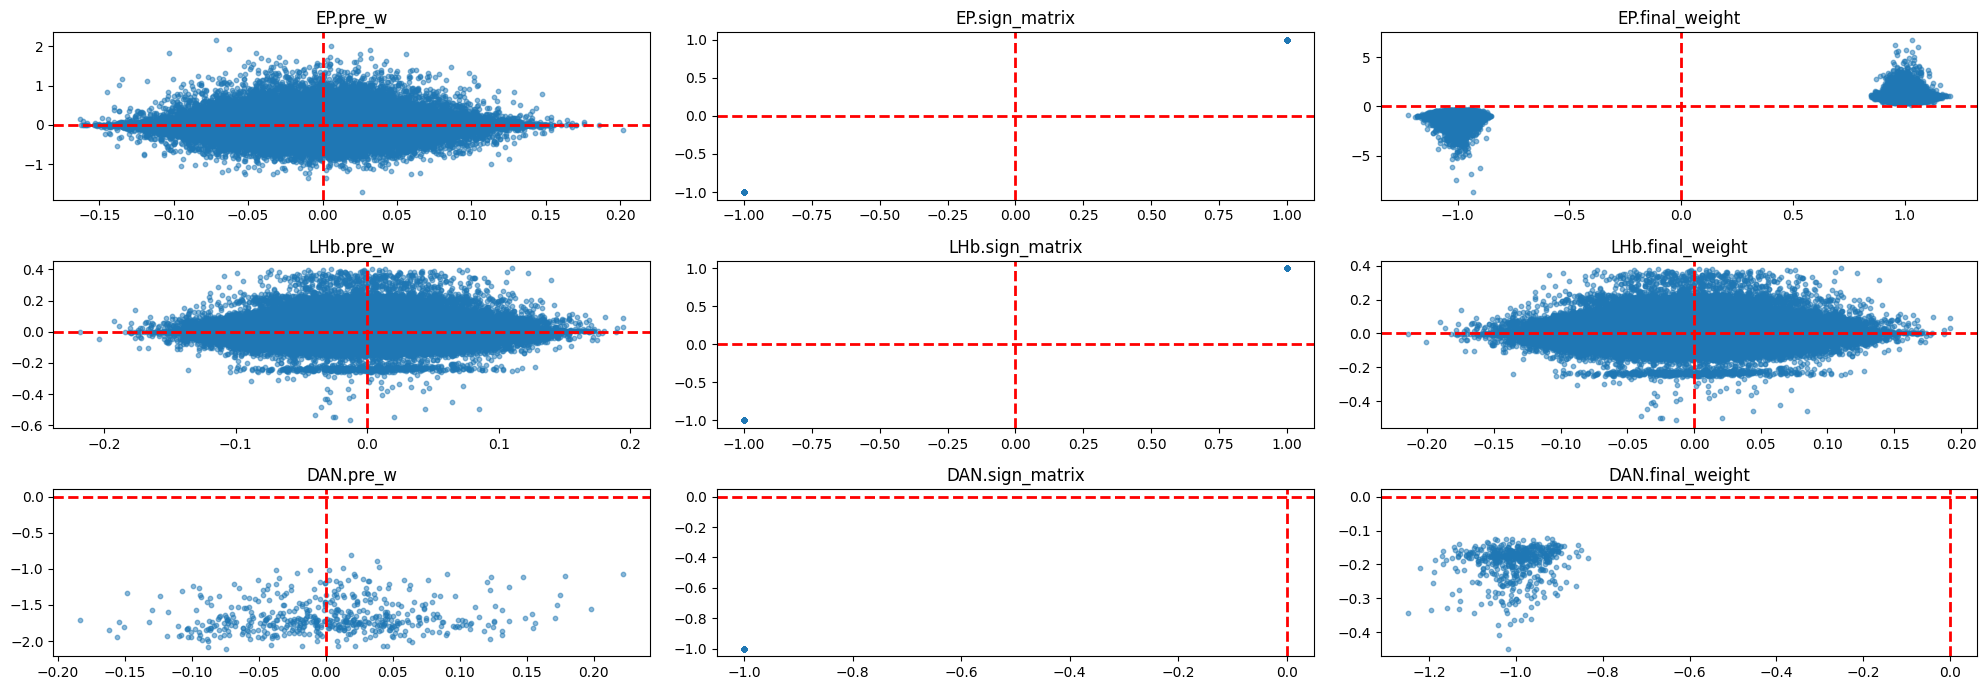

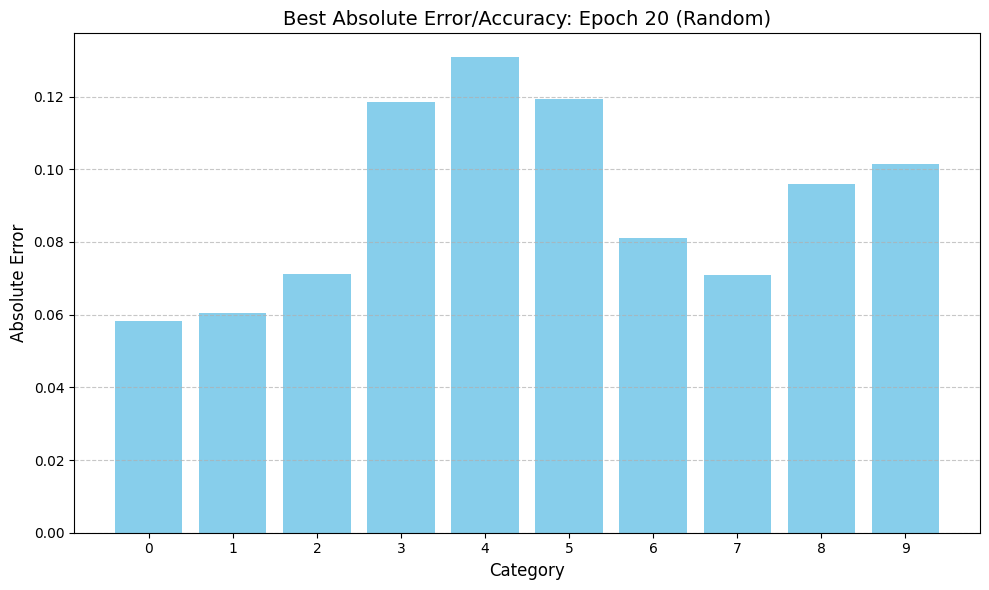

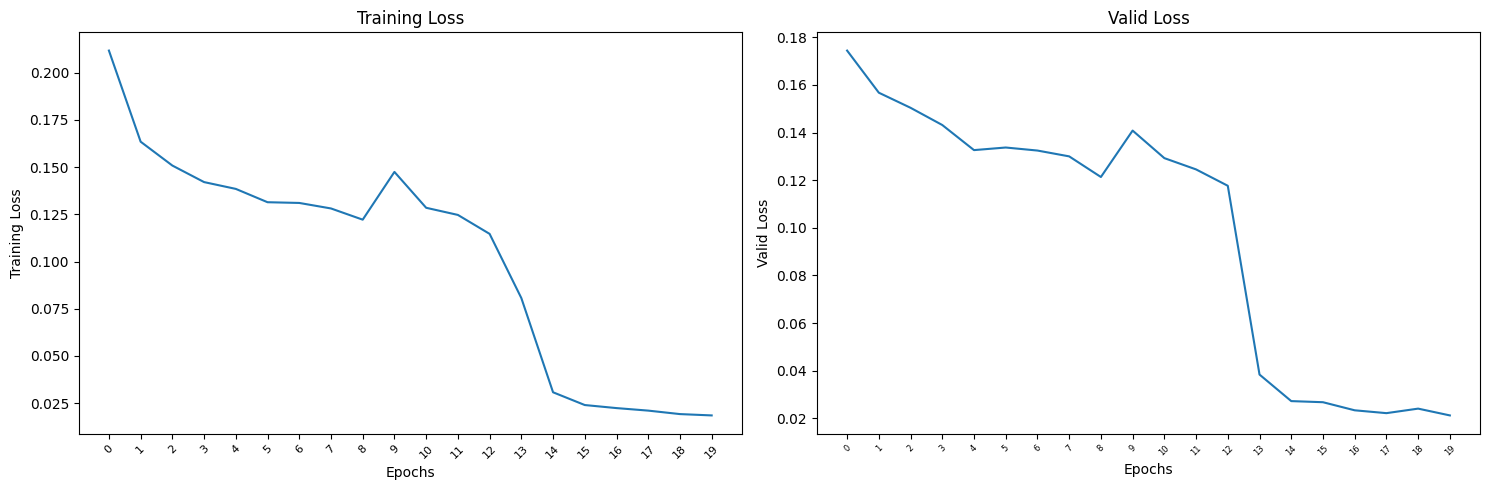

In [7]:
if random_learning:
    # record initial params
    initial_params = model.record_params().copy()
    initial_params_summary[network_name] = [initial_params.copy()]

    # random train
    random_results = TrainerMLE(optimizer = optimizer).train(model, random_train_data, random_valid_data, criterion, opto_category, epochs = epochs)

    # record trained params
    trained_params = model.record_params().copy()
    trained_params_summary[network_name] = [trained_params.copy()]

    # weight plot
    weight_changes(initial_params, trained_params)

    # store random activations
    random_activations = get_activations(model,random_opto_loader)
    
    # random accuracy/loss
    plot_distance(random_results, name = "Random")
    plot_loss(random_results)

### Freeze all layers except EP->LHb, then train EP->LHb to learn reward stimulus/ label.

In [8]:
# Before reward/punish training, freeze all layers except LHb
params_to_optimize = [model.LHb.pre_w]

# update adam optimizer
optimizer = optim.Adam(params = params_to_optimize, lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)

EP.pre_w: Positive: 48.38%; Negative: 51.62%; Zero: 0.00%
EP.sign_matrix: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
EP.final_weight: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
LHb.pre_w: Positive: 51.58%; Negative: 48.42%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.04%; Negative: 49.96%; Zero: 0.00%
LHb.final_weight: Positive: 51.58%; Negative: 48.42%; Zero: 0.00%
DAN.pre_w: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
 ----   Epoch 1  ---- 
training loss: 0.02 | validation loss: 0.03
time elapsed: 3.93 s | predicted time remaining: 74.65 s
 ----   Epoch 2  ---- 
training loss: 0.02 | validation loss: 0.03
time elapsed: 7.06 s | predicted time remaining: 63.57 s
 ----   Epoch 3  ---- 
training loss: 0.02 | validation loss: 0.03
time elapsed: 10.02 s | predicted time remaining: 56.79 s
 ----   Epoch 4  ---- 
training loss: 0.02 | validation loss

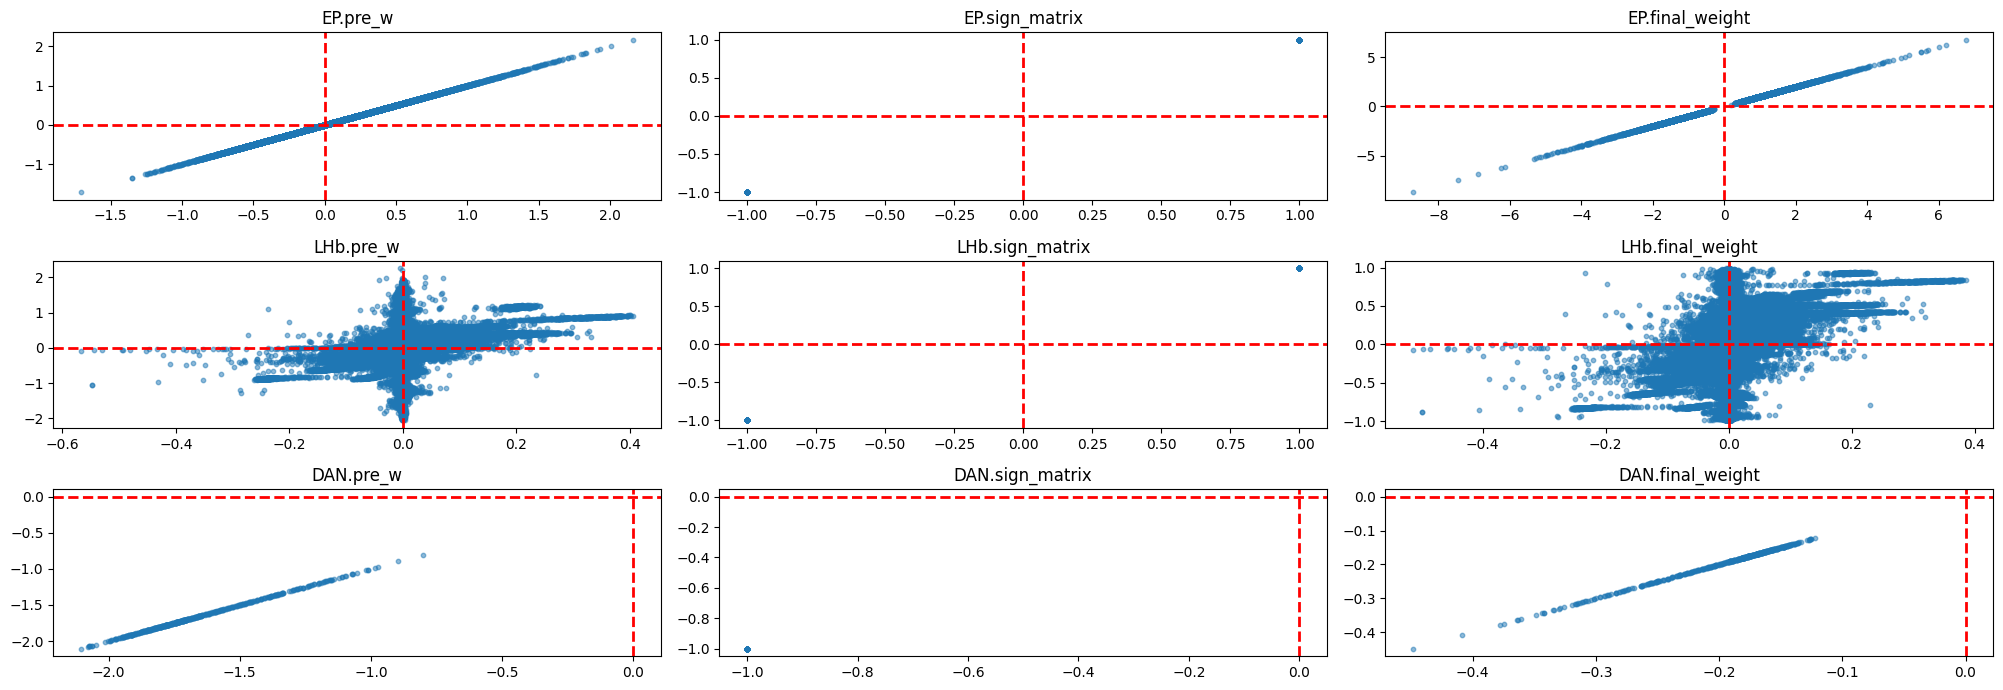

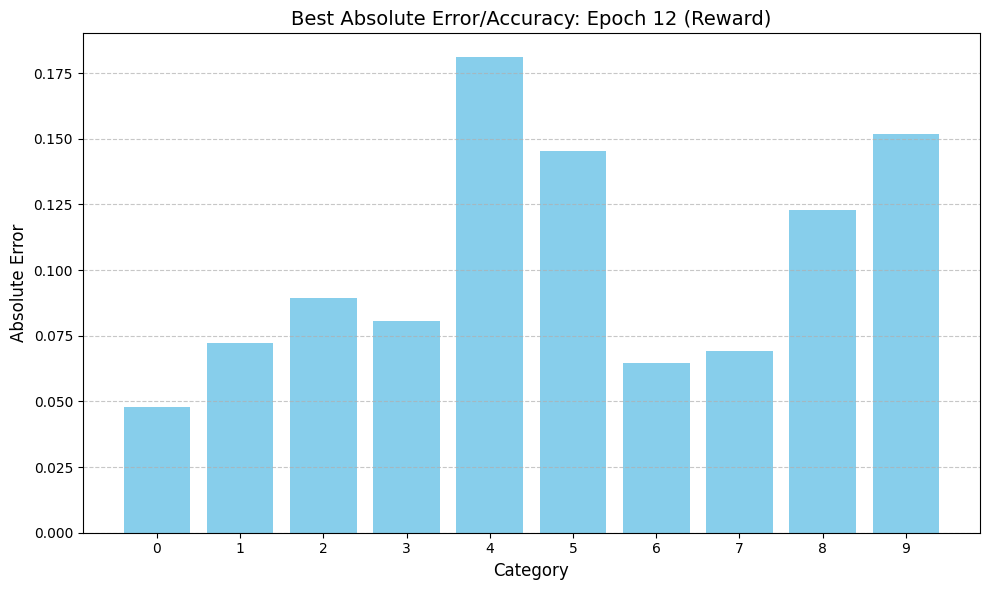

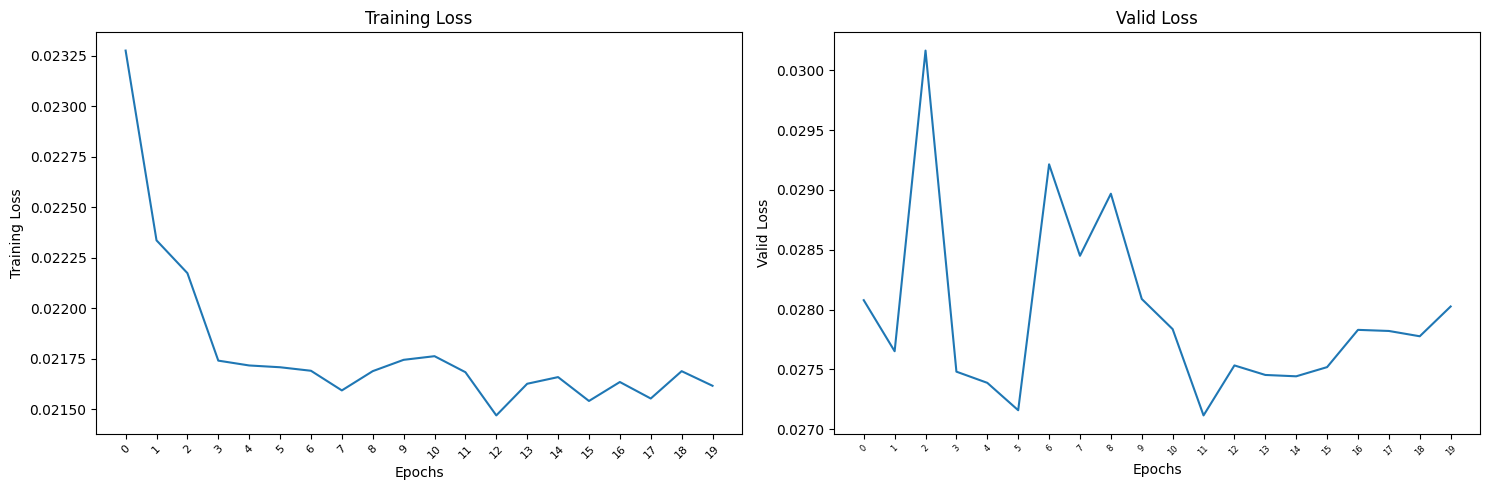

In [9]:
if reward_learning:
    # record initial params
    initial_params = model.record_params().copy()
    initial_params_summary[network_name].append(initial_params.copy())

    # reward train
    reward_results = TrainerMLE(optimizer = optimizer).train(model, reward_train_data, reward_valid_data, criterion, opto_category, epochs = epochs)

    # record trained params
    trained_params = model.record_params().copy()
    trained_params_summary[network_name].append(trained_params.copy())

    # weight plot
    weight_changes(initial_params, trained_params)

    # store reward activations
    reward_activations = get_activations(model,reward_opto_loader)
    
    # reward accuracy/loss
    plot_distance(reward_results, name = "Reward")
    plot_loss(reward_results)

### Keep all layers except EP->LHb frozen, train EP->LHb to learn punish stimulus/ label.

EP.pre_w: Positive: 48.38%; Negative: 51.62%; Zero: 0.00%
EP.sign_matrix: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
EP.final_weight: Positive: 50.05%; Negative: 49.95%; Zero: 0.00%
LHb.pre_w: Positive: 49.56%; Negative: 50.44%; Zero: 0.00%
LHb.sign_matrix: Positive: 50.04%; Negative: 49.96%; Zero: 0.00%
LHb.final_weight: Positive: 49.56%; Negative: 50.44%; Zero: 0.00%
DAN.pre_w: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.sign_matrix: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
DAN.final_weight: Positive: 0.00%; Negative: 100.00%; Zero: 0.00%
 ----   Epoch 1  ---- 
training loss: 0.02 | validation loss: 0.03
time elapsed: 2.68 s | predicted time remaining: 50.83 s
 ----   Epoch 2  ---- 
training loss: 0.02 | validation loss: 0.03
time elapsed: 5.41 s | predicted time remaining: 48.70 s
 ----   Epoch 3  ---- 
training loss: 0.02 | validation loss: 0.02
time elapsed: 7.91 s | predicted time remaining: 44.81 s
 ----   Epoch 4  ---- 
training loss: 0.02 | validation loss:

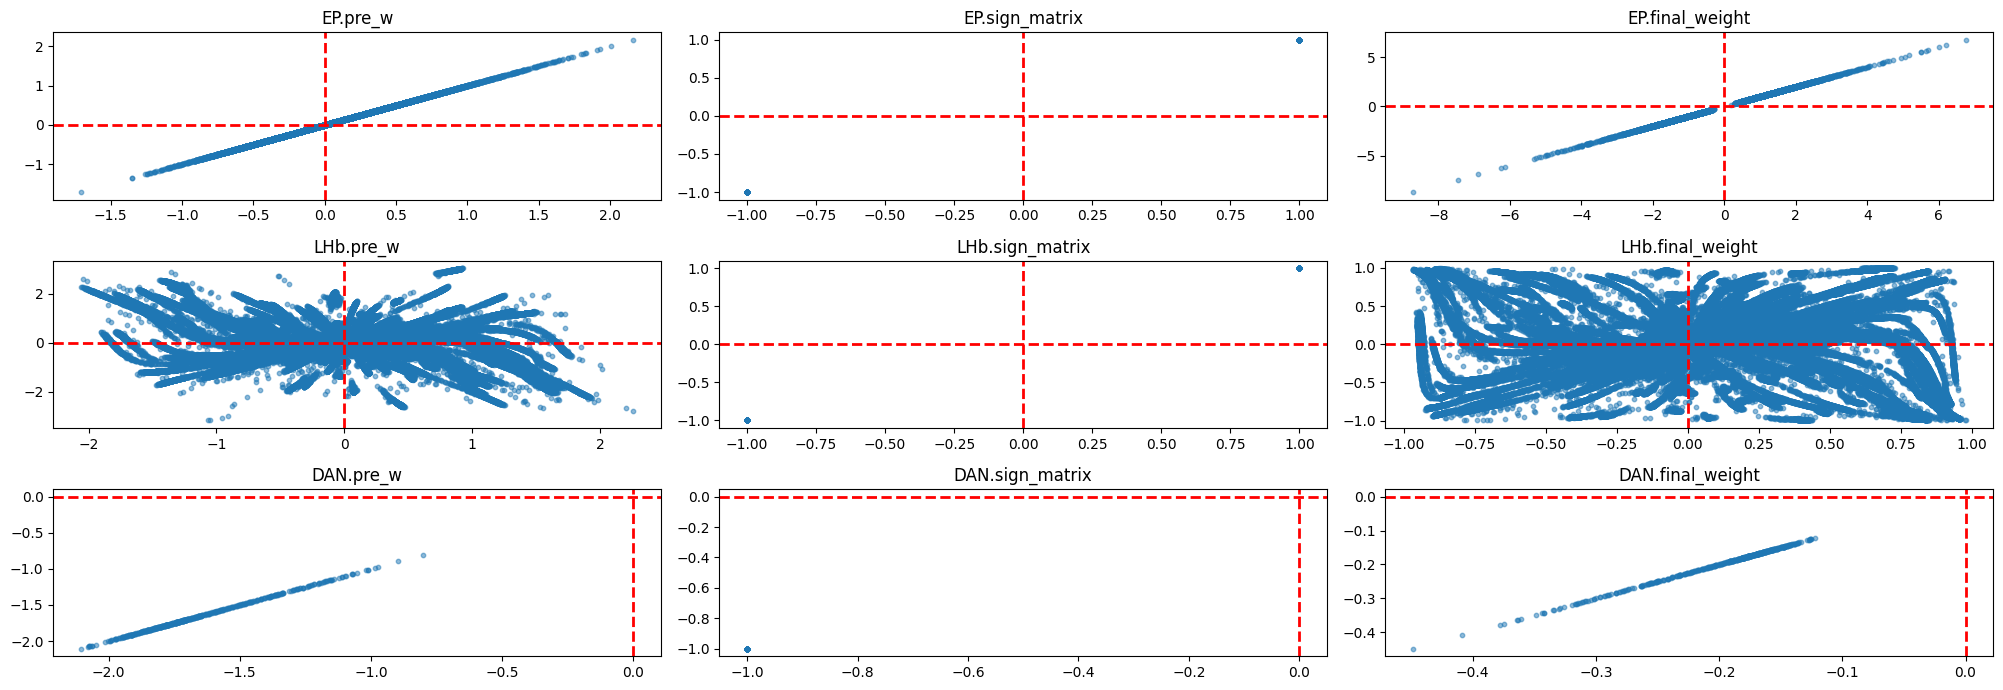

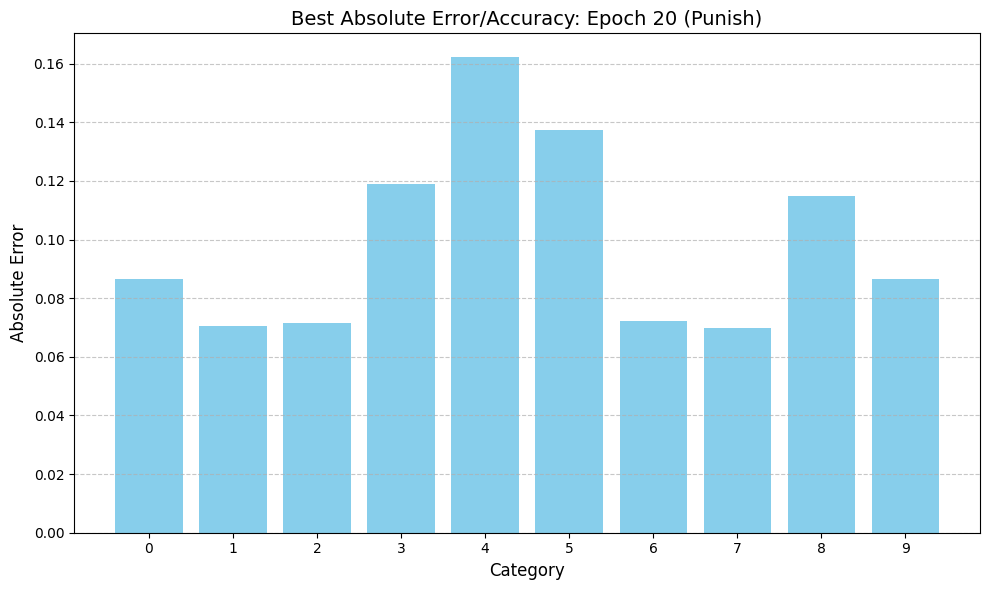

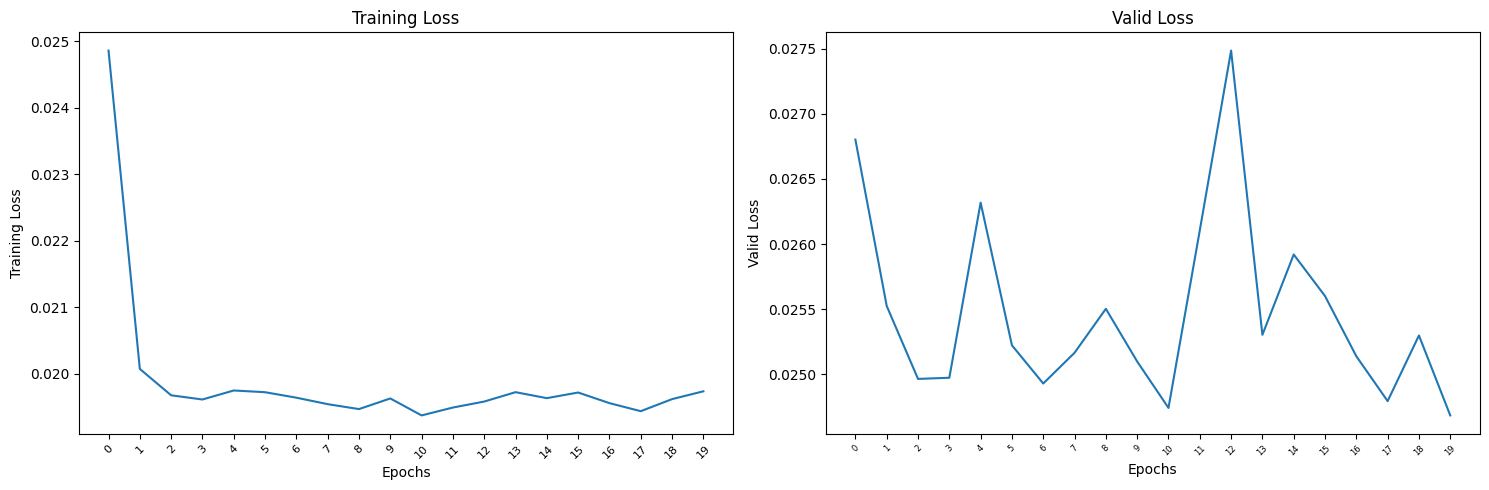

In [10]:
if punish_learning: 
    # record initial params
    initial_params = model.record_params().copy()
    initial_params_summary[network_name].append(initial_params.copy())

    # punish train
    punish_results = TrainerMLE(optimizer = optimizer).train(model, punish_train_data, punish_valid_data, criterion, opto_category, epochs = epochs)

    # record trained params
    trained_params = model.record_params().copy()
    trained_params_summary[network_name].append(trained_params.copy())

    # weight plot
    weight_changes(initial_params, trained_params)

    # store punish activations
    punish_activations = get_activations(model,punish_opto_loader)
    
    # punish accuracy/loss
    plot_distance(punish_results, name = "Punish")
    plot_loss(punish_results)

### Track Activation Changes after each training (initial, reward, punish)
- Ctx-EP has no change: a product of freezing layers after initial training
- EP-LHb has opposite change as target to combat negative LHb-> DAN (ex. negative change for reward stimuli of 1)
- LHb-> DAN accurately represents learning of optogenetic stimulus/input and target value.

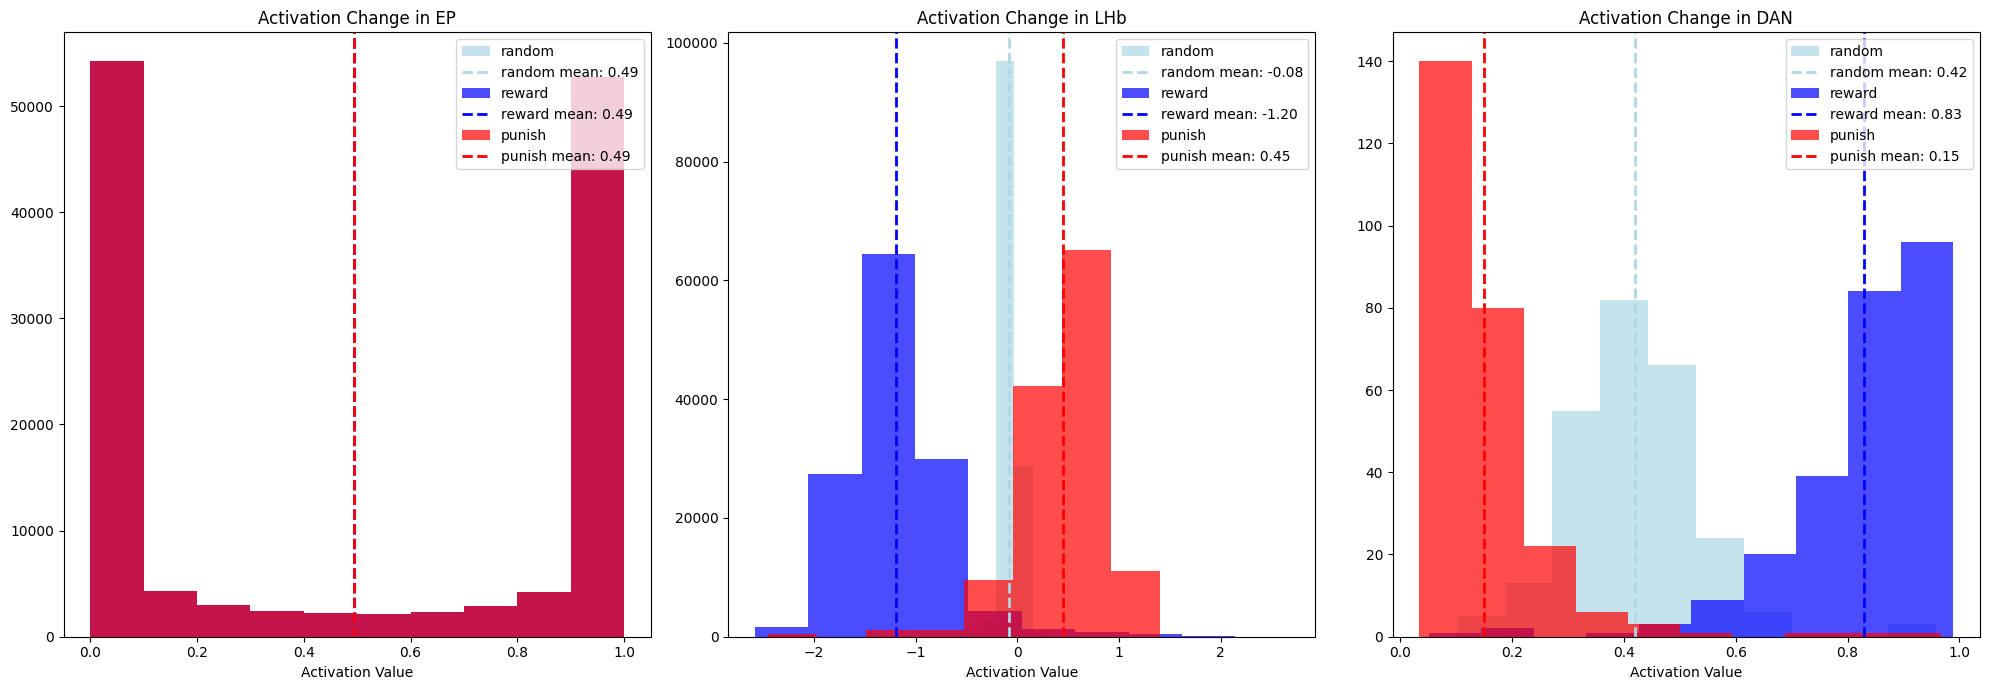

In [11]:
# Plot activation values
activations = []
if random_learning: activations.append(random_activations)
if reward_learning: activations.append(reward_activations)
if punish_learning: activations.append(punish_activations)

plot_layer_activation(activations,plot=[random_learning,reward_learning,punish_learning])

### Store Data

In [12]:
# get initial and trained params for random, reward, punish
params_dict = get_training_params(
    initial_params_summary, 
    trained_params_summary, 
    network_name,
    random_learning=random_learning,
    reward_learning=reward_learning,
    punish_learning=punish_learning
)

# Extract for backward compatibility
random_train_initial_params = params_dict.get('random_train_initial_params')
random_train_trained_params = params_dict.get('random_train_trained_params')
reward_train_initial_params = params_dict.get('reward_train_initial_params')
reward_train_trained_params = params_dict.get('reward_train_trained_params')
punish_train_initial_params = params_dict.get('punish_train_initial_params')
punish_train_trained_params = params_dict.get('punish_train_trained_params')

In [13]:
# Package into pickle file
save_weights_to_pickle(
    model, 
    params_dict,
    random_learning=random_learning,
    reward_learning=reward_learning,
    punish_learning=punish_learning
)

Saving weights to FMNIST_weights_random-reward-punish.pkl


'FMNIST_weights_random-reward-punish.pkl'

### Load Data (if needed)

In [14]:
# # Unpack pickle files
# train_name = "random-reward-punish"

# with open(f'FMNIST_weights_{train_name}.pkl', 'rb') as f:
#     FMNIST_weight = pickle.load(f)

# # Get EP activations and opto indices
# top_act_neurons = FMNIST_weight['top_act_neurons']
# bottom_act_neurons = FMNIST_weight['bottom_act_neurons']

# # Get initial and trained params
# random_learning = "random" in train_name
# reward_learning = "reward" in train_name
# punish_learning = "punish" in train_name

# if random_learning:
#     random_train_initial_params = FMNIST_weight['random_train_initial_params']
#     random_train_trained_params = FMNIST_weight['random_train_trained_params']

# if reward_learning:
#     reward_train_initial_params = FMNIST_weight['reward_train_initial_params']
#     reward_train_trained_params = FMNIST_weight['reward_train_trained_params']
    
# if punish_learning:
#     punish_train_initial_params = FMNIST_weight['punish_train_initial_params']
#     punish_train_trained_params = FMNIST_weight['punish_train_trained_params']

In [15]:
# Setup for analysis
opto_neurons = model.opto_choose_neuron
lowest_neurons = model.lowest_choose_neuron
LHb_plt_name = 'LHb.final_weight'

# Get the layer key from params (for plotting)
if random_train_initial_params:
    LHb_weight = list(random_train_initial_params)[5]  # Key for LHb layer in params dict
else:
    LHb_weight = 'LHb.final_weight'

# Decide what to plot
plot_random = random_learning
plot_reward = reward_learning
plot_punish = punish_learning

In [16]:
# Step 1: Create a tensor with values from 1 to 512
all_values = torch.arange(0, 512)
non_opto_neurons = all_values[~torch.isin(all_values, torch.tensor(opto_neurons))]

In [17]:
# Calculate all weight metrics for all training phases
all_metrics = calculate_all_weight_metrics(
    params_dict,
    LHb_plt_name,
    opto_neurons,
    lowest_neurons,
    random_learning=random_learning,
    reward_learning=reward_learning,
    punish_learning=punish_learning
)

# Extract metrics for backward compatibility (if needed for other code)
if 'random' in all_metrics:
    random_train_trained_exci_top = all_metrics['random']['top']['exci']
    random_train_trained_inhi_top = all_metrics['random']['top']['inhi']
    random_train_trained_EIindex_top = all_metrics['random']['top']['EIindex']
    random_weight_diff_top = all_metrics['random']['top']['weight_diff']
    
    random_train_trained_exci_bot = all_metrics['random']['bottom']['exci']
    random_train_trained_inhi_bot = all_metrics['random']['bottom']['inhi']
    random_train_trained_EIindex_bot = all_metrics['random']['bottom']['EIindex']
    random_weight_diff_bot = all_metrics['random']['bottom']['weight_diff']
    
    random_train_trained_exci_all = all_metrics['random']['all']['exci']
    random_train_trained_inhi_all = all_metrics['random']['all']['inhi']
    random_train_trained_EIindex_all = all_metrics['random']['all']['EIindex']
    random_weight_diff_all = all_metrics['random']['all']['weight_diff']

if 'reward' in all_metrics:
    reward_train_trained_exci_top = all_metrics['reward']['top']['exci']
    reward_train_trained_inhi_top = all_metrics['reward']['top']['inhi']
    reward_train_trained_EIindex_top = all_metrics['reward']['top']['EIindex']
    reward_weight_diff_top = all_metrics['reward']['top']['weight_diff']
    
    reward_train_trained_exci_bot = all_metrics['reward']['bottom']['exci']
    reward_train_trained_inhi_bot = all_metrics['reward']['bottom']['inhi']
    reward_train_trained_EIindex_bot = all_metrics['reward']['bottom']['EIindex']
    reward_weight_diff_bot = all_metrics['reward']['bottom']['weight_diff']
    
    reward_train_trained_exci_all = all_metrics['reward']['all']['exci']
    reward_train_trained_inhi_all = all_metrics['reward']['all']['inhi']
    reward_train_trained_EIindex_all = all_metrics['reward']['all']['EIindex']
    reward_weight_diff_all = all_metrics['reward']['all']['weight_diff']

if 'punish' in all_metrics:
    punish_train_trained_exci_top = all_metrics['punish']['top']['exci']
    punish_train_trained_inhi_top = all_metrics['punish']['top']['inhi']
    punish_train_trained_EIindex_top = all_metrics['punish']['top']['EIindex']
    punish_weight_diff_top = all_metrics['punish']['top']['weight_diff']
    
    punish_train_trained_exci_bot = all_metrics['punish']['bottom']['exci']
    punish_train_trained_inhi_bot = all_metrics['punish']['bottom']['inhi']
    punish_train_trained_EIindex_bot = all_metrics['punish']['bottom']['EIindex']
    punish_weight_diff_bot = all_metrics['punish']['bottom']['weight_diff']
    
    punish_train_trained_exci_all = all_metrics['punish']['all']['exci']
    punish_train_trained_inhi_all = all_metrics['punish']['all']['inhi']
    punish_train_trained_EIindex_all = all_metrics['punish']['all']['EIindex']
    punish_weight_diff_all = all_metrics['punish']['all']['weight_diff']


### Plot Weight Changes

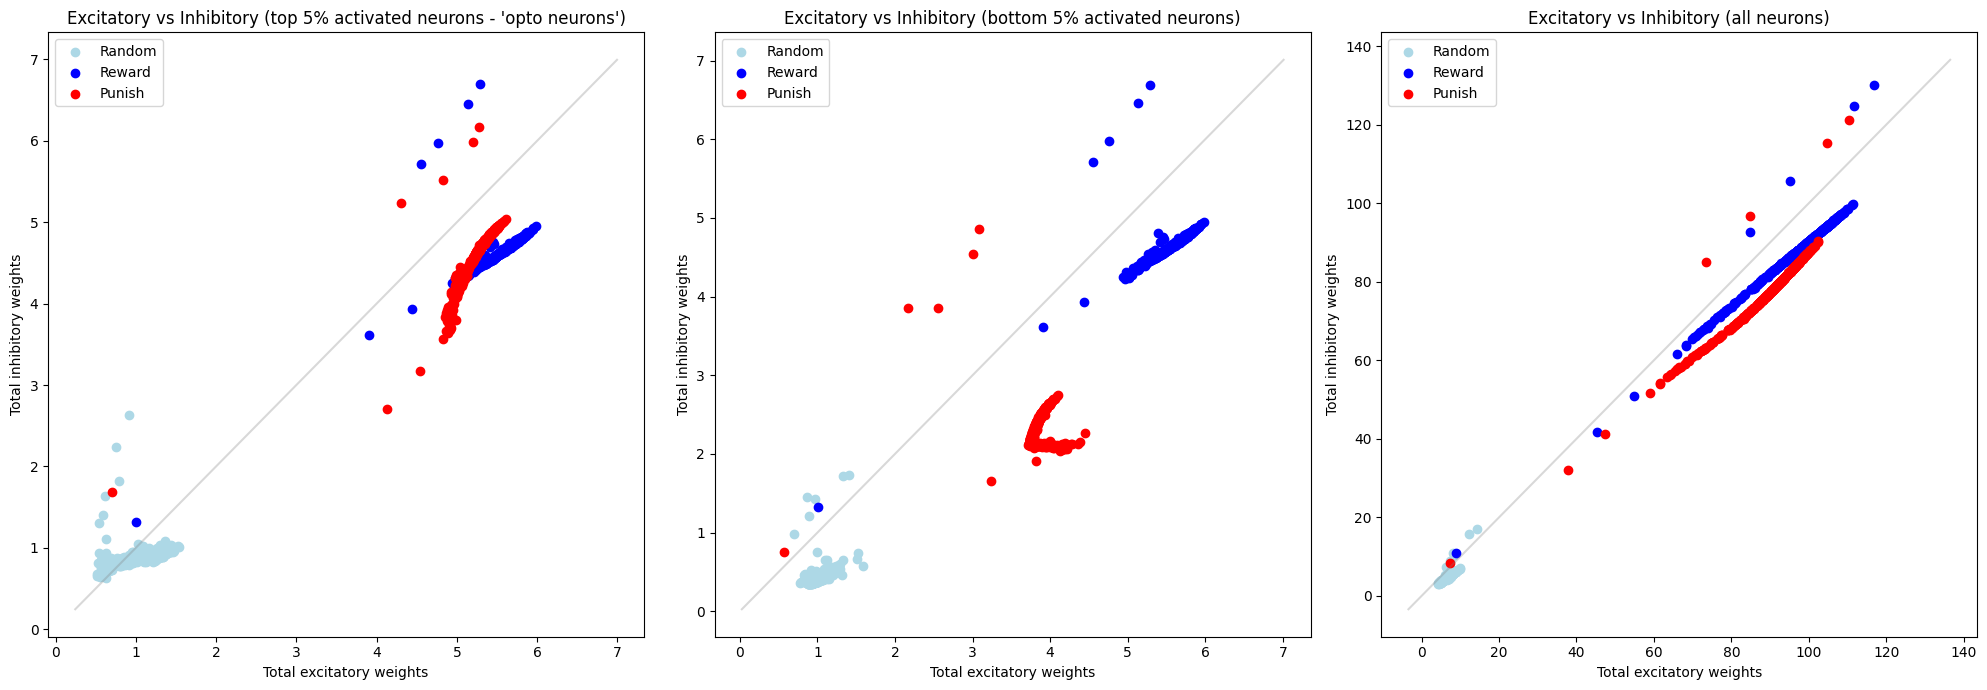

In [18]:
# Plot excitatory vs inhibitory scatter plots
plot_excitatory_inhibitory_scatter(all_metrics,plot_random,plot_reward,plot_punish)

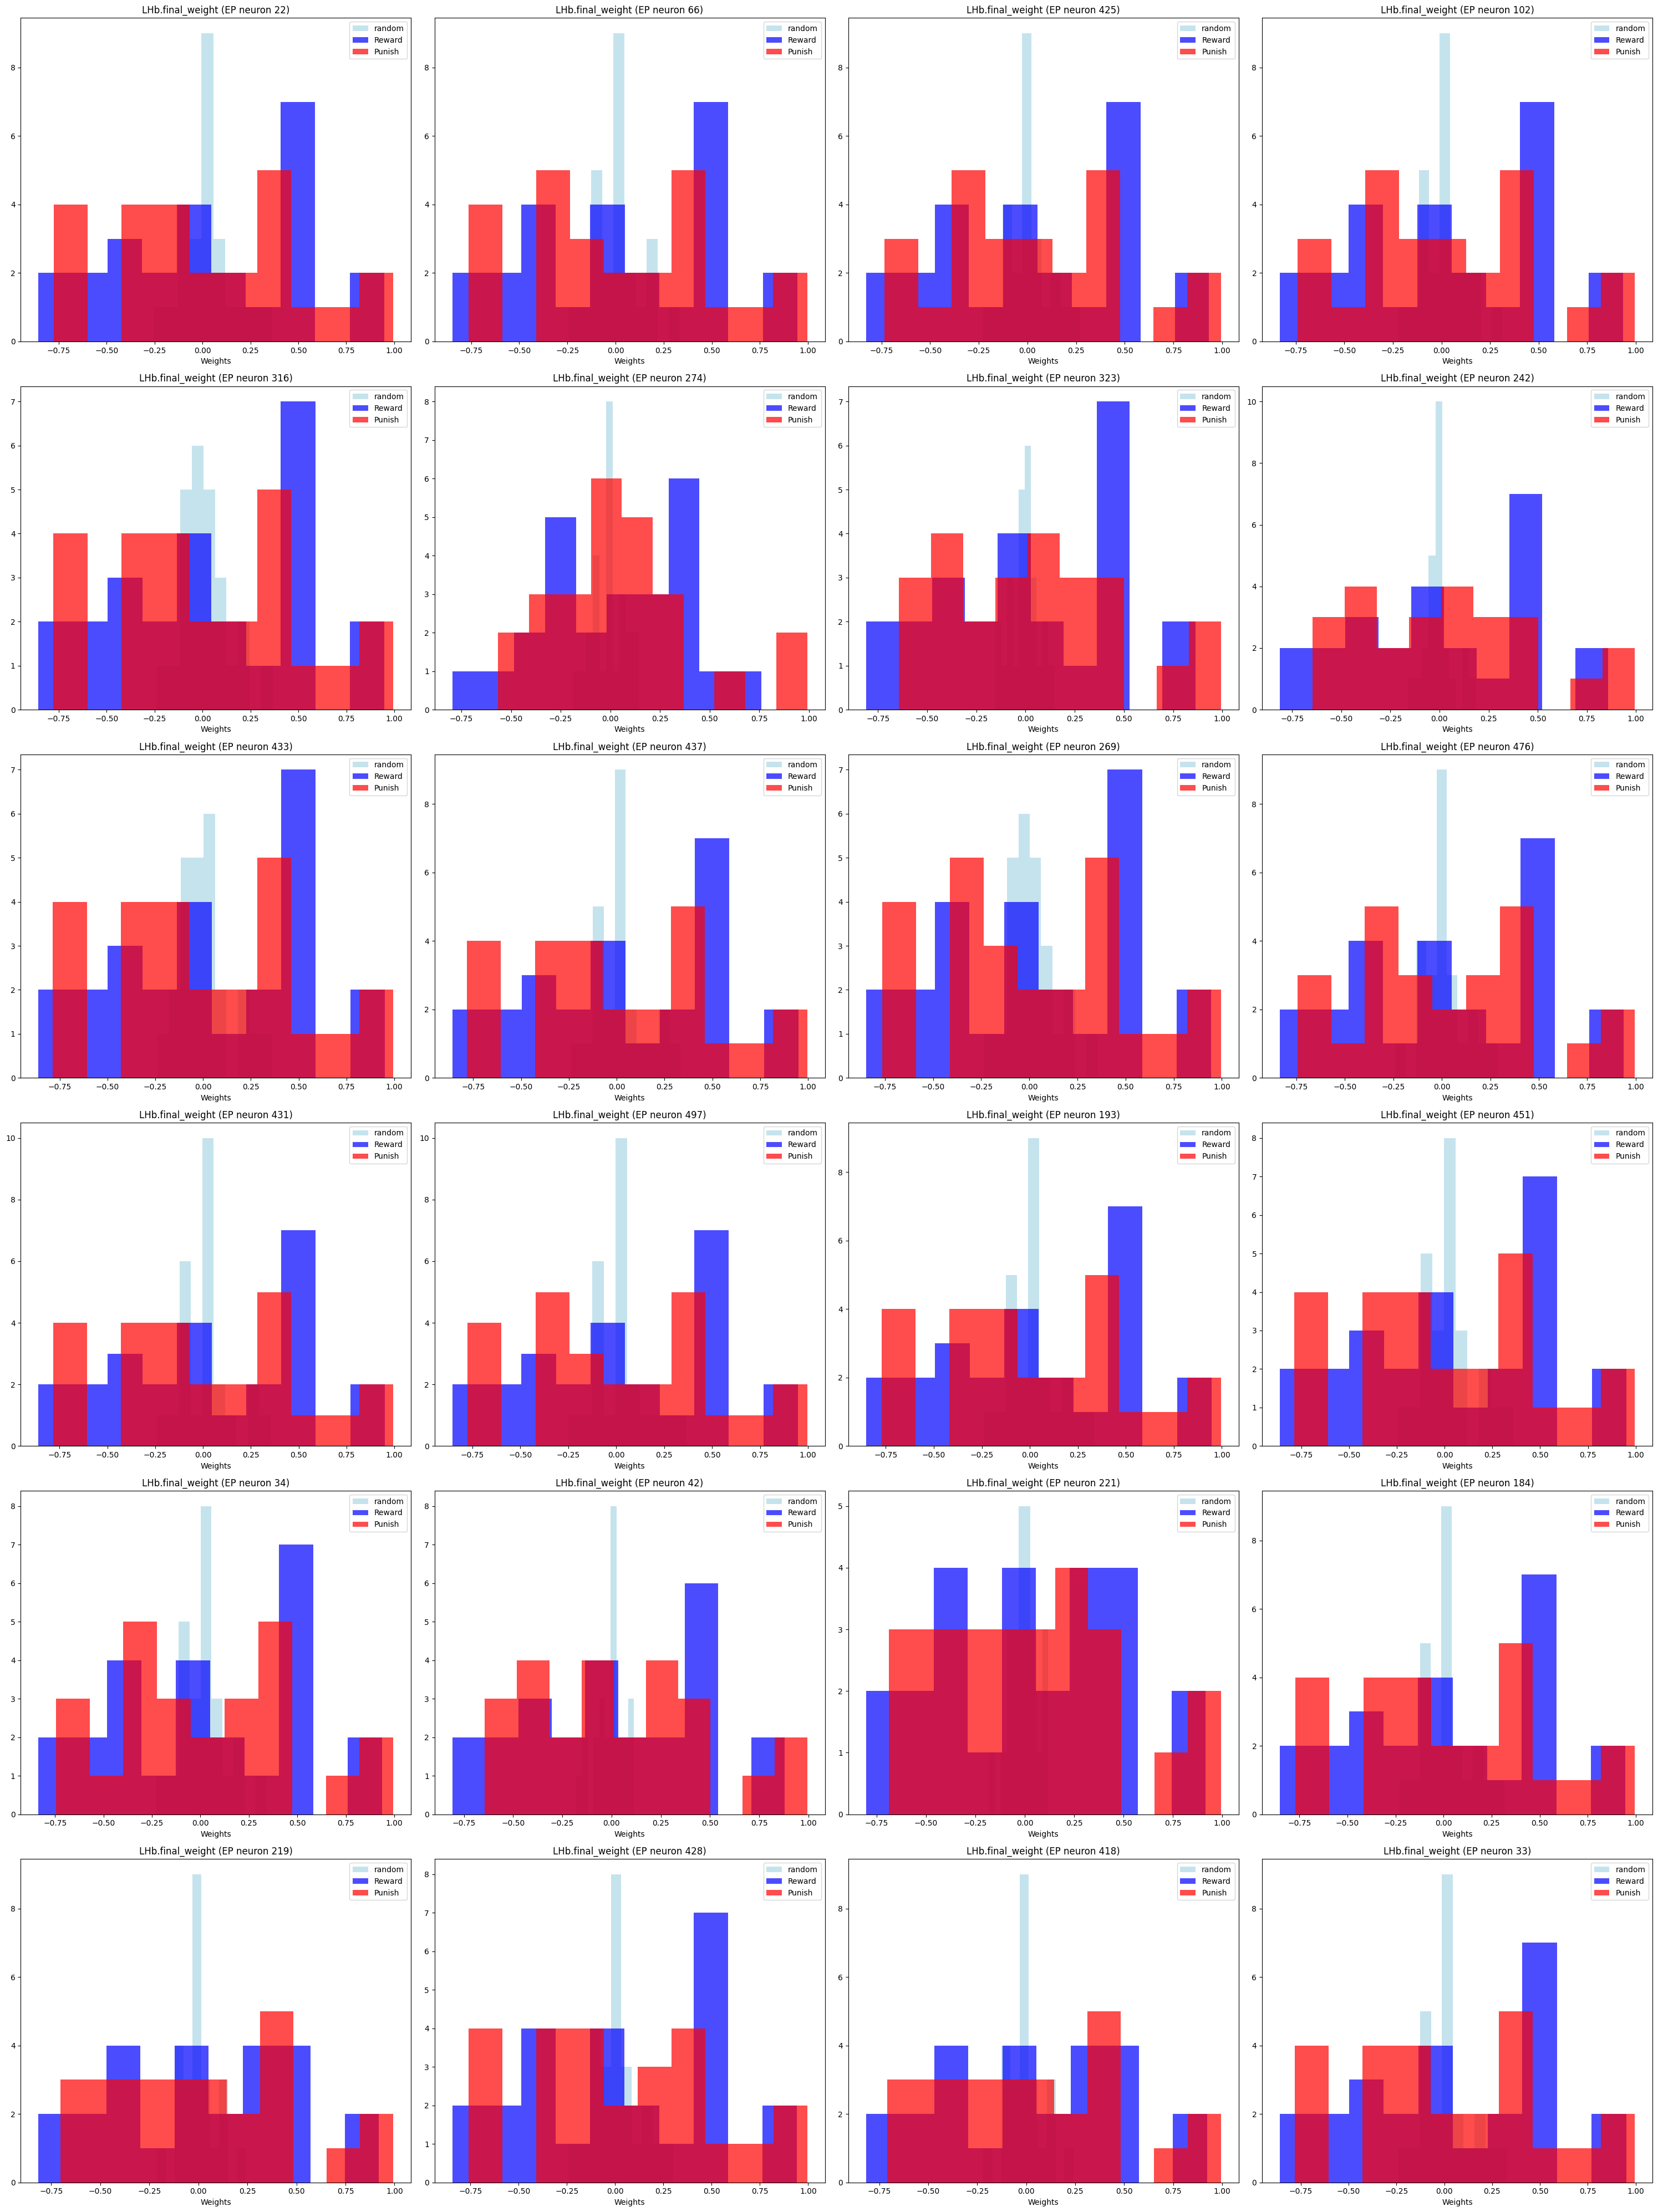

In [19]:
# Plot weight histograms for opto neurons
# Create a dict with trained params for the plotting function
trained_params_dict = {}
if plot_random and 'random_train_trained_params' in params_dict:
    trained_params_dict['random'] = params_dict['random_train_trained_params']
if plot_reward and 'reward_train_trained_params' in params_dict:
    trained_params_dict['reward'] = params_dict['reward_train_trained_params']
if plot_punish and 'punish_train_trained_params' in params_dict:
    trained_params_dict['punish'] = params_dict['punish_train_trained_params']

plot_weight_histograms(trained_params_dict,LHb_weight,opto_neurons,plot_random,plot_reward,plot_punish)

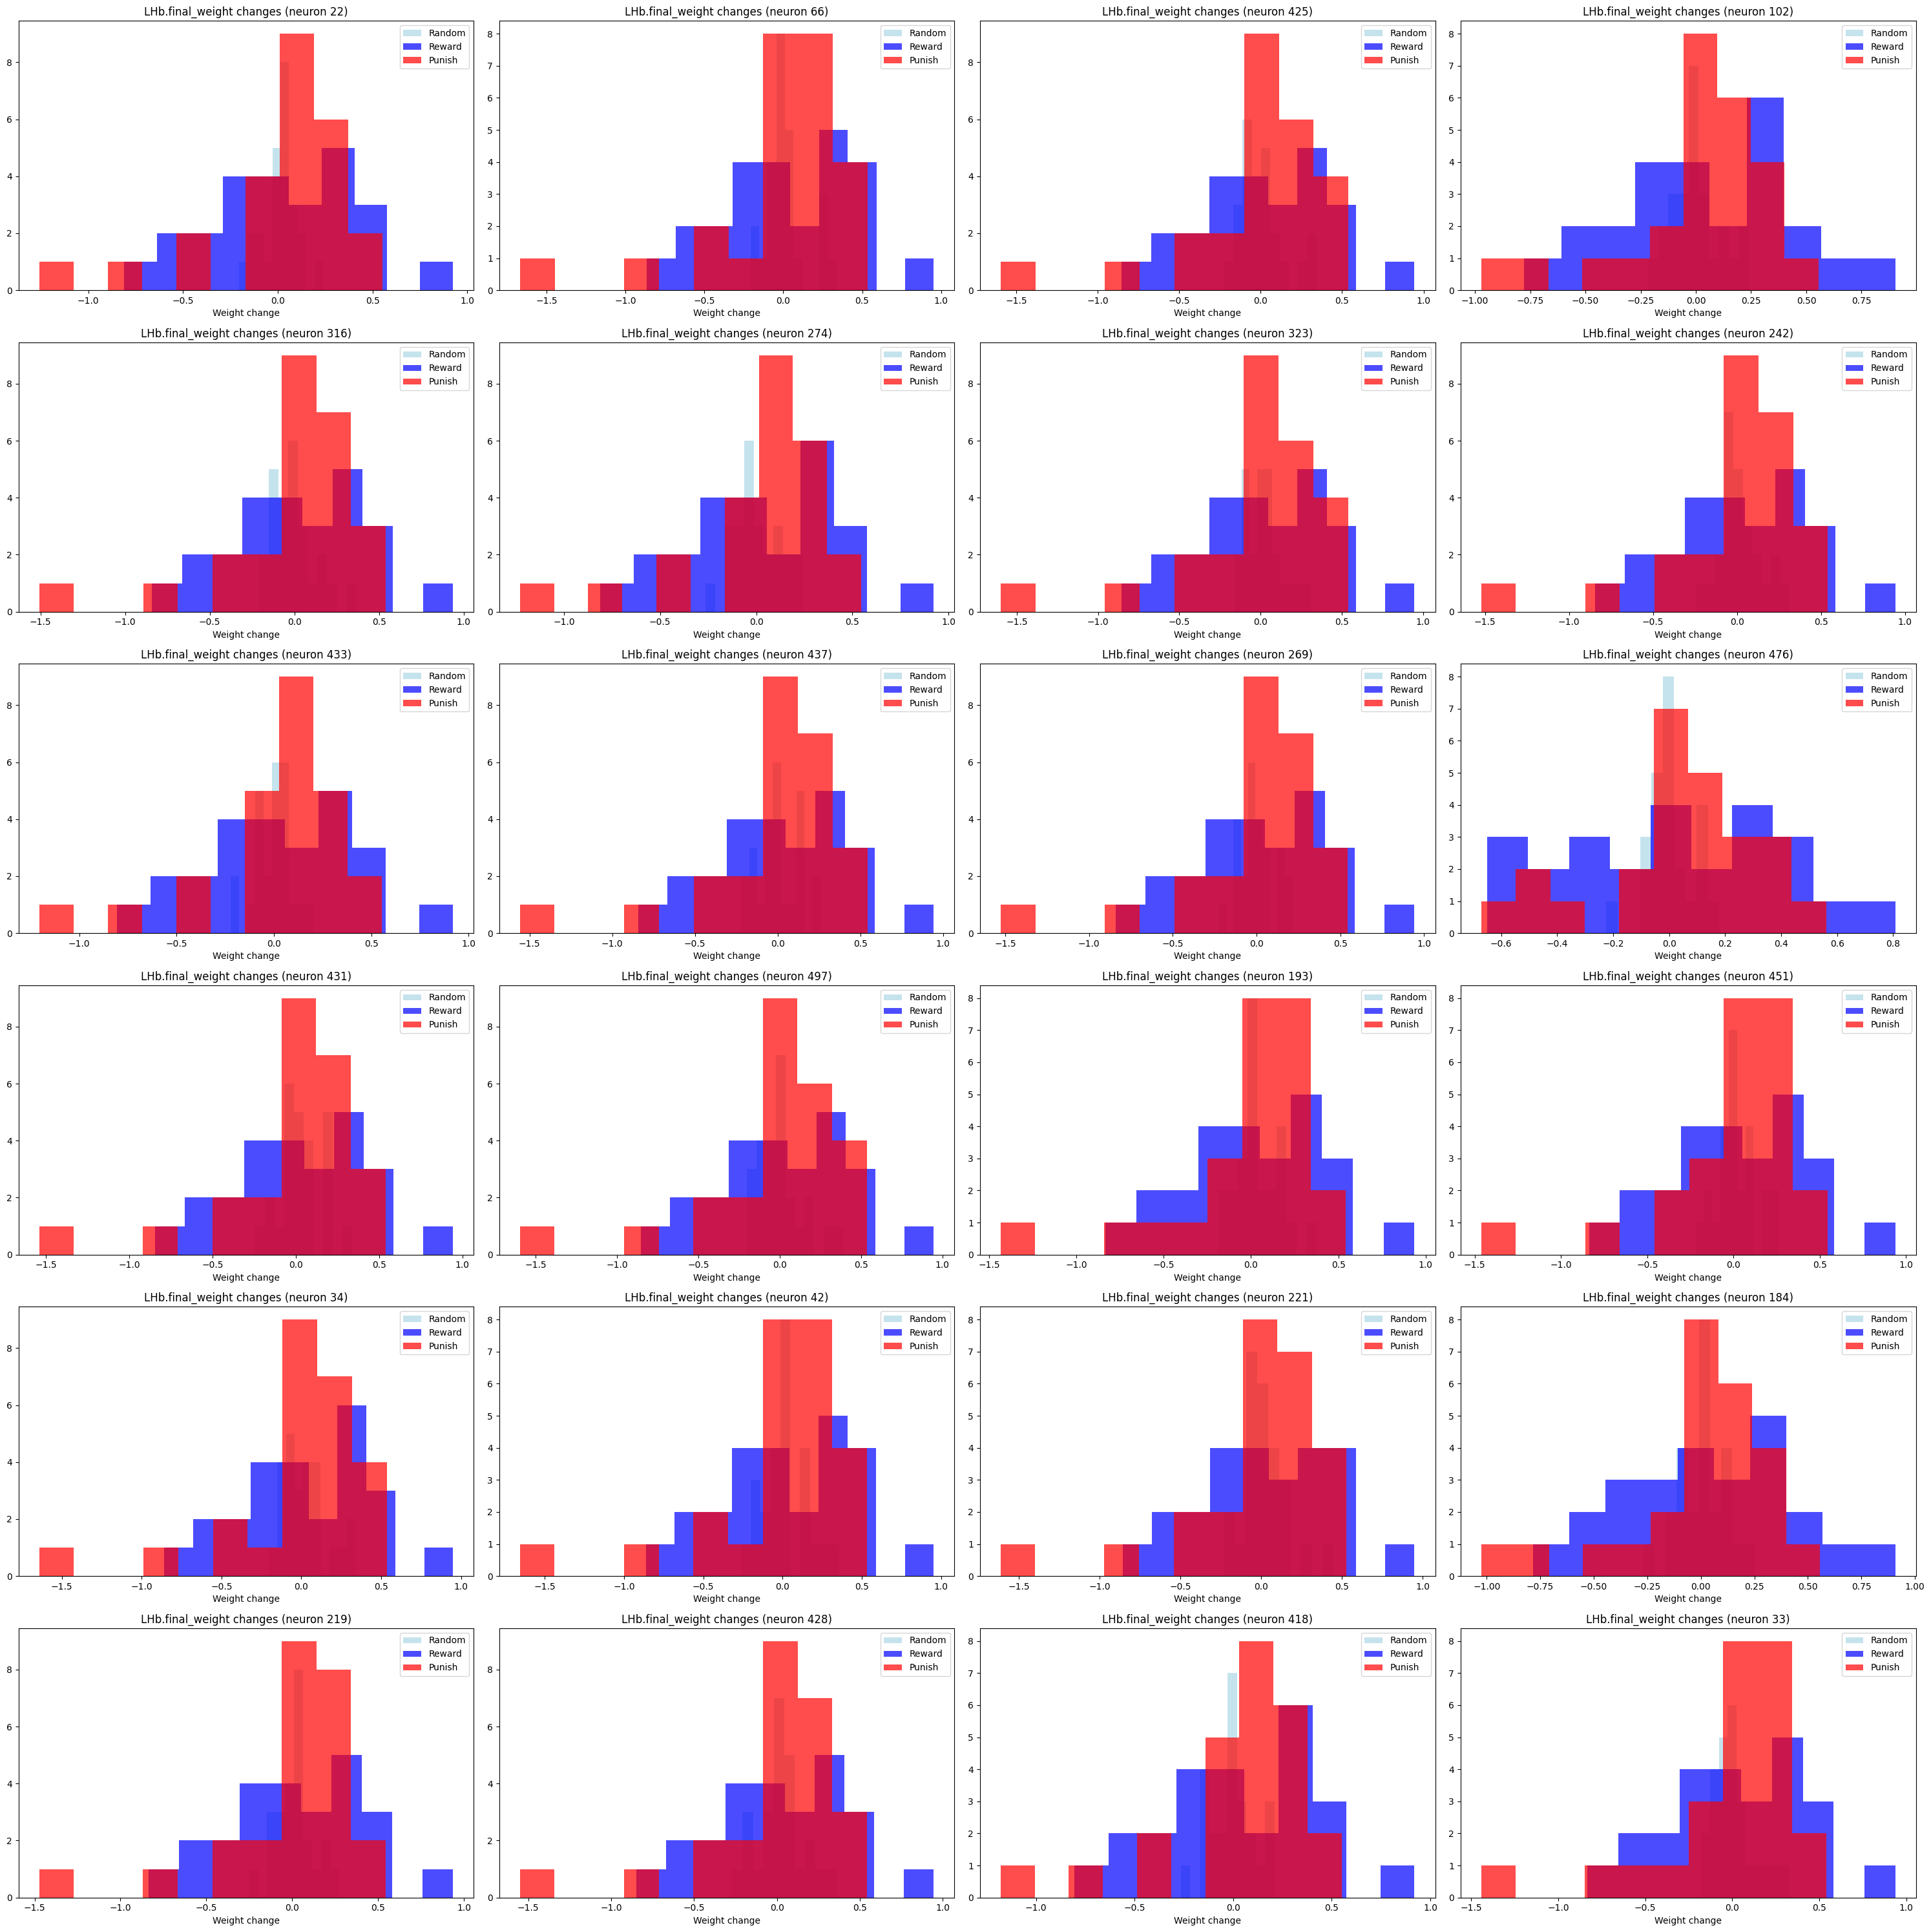

In [20]:
# Plot weight difference histograms
plot_weight_differences(all_metrics, LHb_plt_name, opto_neurons, plot_random=plot_random, plot_reward=plot_reward,plot_punish=plot_punish)

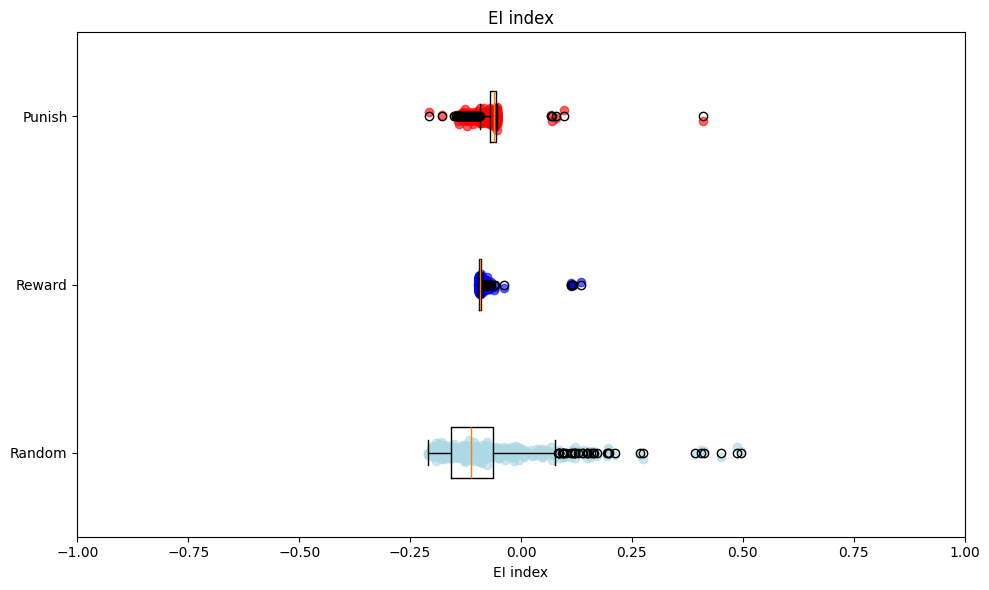

In [21]:
# Plot EI index distribution
plot_EI_index_distribution( all_metrics, plot_random=plot_random, plot_reward=plot_reward, plot_punish=plot_punish)